# Bounding configuration GP example

This notebook is designed to test whether a simple simple comprised of bounding boxes can be generated using [deap](http://deap.readthedocs.io/en/master/api/tools.html), a Python Evolutionary Algorithm Package.

In [1]:
import copy

import numpy as np

from functools import partial

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


In [2]:
# def progn(*args):
#     for arg in args:
#         arg()

# def prog2(out1, out2): 
#     return partial(progn,out1,out2)

# def prog3(out1, out2, out3):     
#     return partial(progn,out1,out2,out3)

# def if_then_else(condition, out1, out2):
#     out1() if condition() else out2()



In [9]:
from OCC.gp import gp_Pnt
from airconics.base import AirconicsShape, AirconicsCollection
from airconics import LiftingSurface, Fuselage, Engine
from OCC.gp import gp_Ax2
import OCC
from airconics import AirCONICStools as act
from OCC.BRepPrimAPI import BRepPrimAPI_MakeBox, BRepPrimAPI_MakeSphere
import pydot
import types
import functools


class TreeNode(object):
    def __init__(self, part, name, arity):
        """Basic type to define node elements in the topology tree. To be used
        by Topology class.

        Parameters
        ----------
        part - Airconics type Fuselage, LiftingSurface or Engine
            The type to convert

        name - string
            The name of the part (e.g. 'Wing' or 'Fin')

        arity - int
            the number of descendants

        Attributes
        ----------
        arity - int
            arity (number of descendants) of this node.

        name - string
            Name of the part

        func - string
            Indicates the type of node i.e.
        """
        self.name = name
        self.arity = arity

        if type(part) not in FUNCTIONS.values():
            raise TypeError("Not a recognised part type: {}. Should be {}"
                .format(type(part), FUNCTIONS.values()))
        else:
            func_str = FUNCTIONS_INV[type(part)]
        self.func = func_str

    def __str__(self):
        output = '({}, {}, {})'.format(self.name, self.func, self.arity)
        return output


# Create a simple Box class that inherits from AirconicsShape
#  - this will behave similarly to the Engine, Fuselage class etc.
class Box(AirconicsShape):
    def __init__(self, xmin, ymin, zmin, dx, dy, dz):
        # This implicitly calls build
        super(Box, self).__init__(construct_geometry=True,
                                             xmin=xmin,
                                             ymin=ymin,
                                             zmin=zmin,
                                             dx=dx,
                                             dy=dy,
                                             dz=dz)
        
        
        bbox_xmin, bbox_ymin, bbox_zmin, bbox_xmax, bbox_ymax, bbox_zmax = self.Extents()
        self.bbox_xmin = bbox_xmin
        self.bbox_ymin = bbox_ymin
        self.bbox_zmin = bbox_zmin
        self.bbox_xmax = bbox_xmax
        self.bbox_ymax = bbox_ymax
        self.bbox_zmax = bbox_zmax
        
        directions = []
        
    def Build(self):
        Xmin = gp_Pnt(self.xmin, self.ymin, self.zmin)
        Xmax = gp_Pnt(self.xmin + self.dx, self.ymin + self.dy, self.zmin + self.dz)
        self['Box'] = BRepPrimAPI_MakeBox(Xmin, Xmax).Shape()

# Create a simple Box class that inherits from AirconicsShape
#  - this will behave similarly to the Engine, Fuselage class etc.
class Sphere(AirconicsShape):
    def __init__(self, xcenter, ycenter, zcenter, d):
        # This implicitly calls build
        super(Sphere, self).__init__(construct_geometry=True,
                                             xcenter=xcenter,
                                             ycenter=ycenter,
                                             zcenter=zcenter,
                                             d=d)
        
        bbox_xmin, bbox_ymin, bbox_zmin, bbox_xmax, bbox_ymax, bbox_zmax = self.Extents()
        self.bbox_xmin = bbox_xmin
        self.bbox_ymin = bbox_ymin
        self.bbox_zmin = bbox_zmin
        self.bbox_xmax = bbox_xmax
        self.bbox_ymax = bbox_ymax
        self.bbox_zmax = bbox_zmax
        
    def Build(self):
        Xcenter = gp_Pnt(self.xcenter, self.ycenter, self.zcenter)
        self['Sphere'] = BRepPrimAPI_MakeSphere(Xcenter, self.d/2).Shape()


        
# This dictionary will be used for topology tree formatting
FUNCTIONS = {'E': Fuselage,         # E = Enclosure
             'L': LiftingSurface,   # L = Lifting Surface
             'P': Engine,           # P = Propulsion
             '|': gp_Ax2,           # M = Mirror Plane
             'B': Box,
             '': None,
             'C': Sphere}

# Reversed dictionary for manually adding shapes, i.e. converting
#  a class instance to a string
FUNCTIONS_INV = {func: name for name, func in FUNCTIONS.items()}

# The shapes of nodes in the exported graph from Topo class:
NODE_PROPERTIES = {Fuselage: {'shape': 'ellipse', 'fill':'#136ed4'},
          LiftingSurface: {'shape': 'box','fill':'#136ed4'},
          Engine: {'shape': 'hexagon', 'fill':'#136ed4'},
          gp_Ax2: {''},         # variables here are not used: mirror is a special case
          Box: {'shape': 'box', 'fill':'#136ed4'},
          types.NoneType : {'shape': 'point'},
          float: {'shape': 'ellipse'},
          int: {'shape': 'ellipse'},
          Sphere: {'shape': 'circle', 'fill':'#136ed4'}}

###################################################################################
# Some trickery is needed to automatically define the BoxLayout functions for generating
# nodes with up to a defined number of attachments :
# def autodefine_functions(cls):
#     for comptype in cls.component_types:
#         for i in range(cls.max_attachments + 1):
#             name = comptype.__name__.lower()
#             print(name)
#             def partial_methodi(self, *args, **kwargs):
#                 # returns a function that pipes all arguments to the function with the 
#                 # same name as the component type + 'N', e.g. fuselageN
#                 return partial(getattr(self, name + 'N'), *args, **kwargs)
#             setattr(cls, name + str(i), partial_methodi)
#             getattr(cls, name + str(i)). __name__ = name + str(i)
#     return cls
# ###################################################################################

# Use a wrapper to convert boxN, sphereN etc. to another function that returns a callable
def wrap_shapeN(shapeN):
    @functools.wraps(shapeN)
    def wrapped_shapeN(*args, **kwargs):
        return partial(shapeN, *args)
    return wrapped_shapeN

# @autodefine_functions
class BoxLayout(AirconicsCollection):
    # Define the max number of sub components that can be attached to a parent geometry
    MaxAttachments = 2
    ComponentTypes = [Box, Sphere, Fuselage]
    
    ArgTypes = {
        Box: [float] * 6,
        Sphere: [float] * 4,
        Fuselage: [float] * 6
    }
    def __init__(self):
        """maxcompoents is the number of components"""
        super(BoxLayout, self).__init__(parts={}, construct_geometry=True)
        
        # Carry around the tree for visualisation purposes:
        self._Tree = []
        self._deap_Tree = None   # This will be populated when 
        
        # Start with a simple box
        self.nparts = 0
        self.routine = None
    
    def __setitem__(self, name, part_w_arity):
        """Overloads the assignment operator used by AirconicsCollection
        to allow only tuples as inputs - arity must be specified for
        topology.

        Parameters
        ----------
        name - string
        part_w_arity - tuple
            (Airconics class, int), eg: (Fuselage, 2) is a Fuselage shape with
            2 descendents in its topological tree

        Notes
        -----
        appends to the self.Tree and self._OrderedParts attributes
        """
        try:
            part, arity = part_w_arity
        except:
            print("Warning: no arity set. Treating as zero")
            part = part_w_arity
            arity = 0

        node = TreeNode(part, name, arity)

        self._Tree.append(node)
        super(BoxLayout, self).__setitem__(name, part)
    
    def run(self, tree, pset):
        self._reset()
        routine = gp.compile(tree, pset)
        self._deap_Tree = tree
        routine()

    def _reset(self):
        self._Parts = {}
        self._Tree = []
        self._deap_Tree = None
        self.nparts = 0

    @wrap_shapeN
    def boxN(self, xmin, ymin, zmin, dx, dy, dz, *args):
        # Fits N new components to this box layout
        box = Box(xmin, ymin, zmin, dx, dy, dz)
        # Do no be confused between the numbering of boxes and the number of descendent
        #  nodes: Each box needs a unique ID, so naming a box0 function "box0" replaces
        #  other shapes in this layout that are also named box0
        self['box{}_{}'.format(len(args), len(self))] = box, len(args)
        
        for arg in args:
            arg()
    
    @wrap_shapeN
    def sphereN(self, xcenter, ycenter, zcenter, r, *args):
        # Fits N new components to this box layout
        sphere = Sphere(xcenter, ycenter, zcenter, r)
        # Do no be confused between the numbering of boxes and the number of descendent
        #  nodes: Each box needs a unique ID, so naming a box0 function "box0" replaces
        #  other shapes in this layout that are also named box0
        self['sphere{}_{}'.format(len(args), len(self))] = sphere, len(args)
        
        for arg in args:
            arg()
    
    @wrap_shapeN
    def fuselageN(self, NoseLengthRatio, TailLengthRatio, Scaling,
                  NoseX, NoseY, NoseZ, *args):
        """Parameter descriptions can be found from the airconics.Fuselage class, all are floats"""
        # Need to add constraints here so that the Fuselage has a good chance of
        # successful lofting: any out of range values will be moved to the
        # nearest boundary:
        arglimits = {NoseLengthRatio: (0.1, 0.3), TailLengthRatio: (0.1, 0.4),
                 Scaling: (1, 100)}
        
        for arg, limit in arglimits.items():
            if arg < limit[0]:
                arglimits[arg] = limit[0]
            elif arg > limit[1]:
                arg = limit[1]

        # Having problems with the fuselage construction:
        #  see if Nose XYZ is causing this
        NoseX = NoseY = NoseZ = 0.

        print(NoseLengthRatio, TailLengthRatio, Scaling)
        # Fits N new components to this box layout
        fus = Fuselage(NoseLengthRatio=NoseLengthRatio,
                       TailLengthRatio=TailLengthRatio,
                       Scaling=[Scaling, Scaling, Scaling],
                       NoseCoordinates=[NoseX, NoseY, NoseZ]
                      )
        # Do no be confused between the numbering of boxes and the number of descendent
        #  nodes: Each box needs a unique ID, so naming a box0 function "box0" replaces
        #  other shapes in this layout that are also named box0
        self['fuselage{}_{}'.format(len(args), len(self))] = fus, len(args)
        
        for arg in args:
            arg()
    
    # Need to automatically define 

    # Now we need to explicitly add the box1, box2, .... boxM functions,
    # So that they can be added to the GP toolbox
#     def box0(self, xmin, ymin, zmin, dx, dy, dz):
#         return partial(self.boxN, xmin, ymin, zmin, dx, dy, dz)
        
#     def box1(self, xmin, ymin, zmin, dx, dy, dz, out1):
#         return partial(self.boxN, xmin, ymin, zmin, dx, dy, dz, out1)

#     def box2(self, xmin, ymin, zmin, dx, dy, dz, out1, out2):
#         return partial(self.boxN, xmin, ymin, zmin, dx, dy, dz, out1, out2)
    
    def temp_fitness(self):
        """Until I come with something useful, the fitness evaluation for this
        configuration will be based on the bounding box volume"""
        try:
            xmin, ymin, zmin, xmax, ymax, zmax = self.Extents()
        except:
            # Bounding Box was probably void
            return 0
        return (xmax-xmin) * (ymax-ymin)*(zmax-zmin)
    
    def pydot_graph(self):
        """Returns a pydot graph instance of a human readable interpretation of
        the topology tree"""
        # Use the _deap_Tree if one is available (stored on calling run(tree, pset)):
        if self._deap_Tree:
            # Note: ns below is a simple range list for every edge/label
            nodes, edges, labels = gp.graph(self._deap_Tree)
        else:
            raise AttributeError("No DEAP GP tree was found: see Box_Layout.run(tree, pset)")
        
        mirror_flag = False
        
        graph = pydot.Dot(splines='ortho', ranksep='0.1')
        graph.set_node_defaults(style='filled')
        graph.set_edge_defaults(arrowhead='none')

        cluster_1 = pydot.Cluster('standard', color='invis')
        graph.add_subgraph(cluster_1)
        
        # Check if a mirror plane exists in the geometry (affects tree visualisation)
        if any(isinstance(component, gp_Ax2) for component in self.values()):
            cluster_2 = pydot.Cluster('mirrored', label='mirrored', style='dashed')
            graph.add_subgraph(cluster_2)
        
        # i is used to increment the number of Geometric parts that have been found in
        # the main loop (required as component names are prepended with their ordinal component
        # number, and component names need to be matched with the _deap_tree)
        i = 0
        
        for node in nodes:
            # note: this only works because the node number is manually added
            # to the label by boxn:
#             print(node)
            try:
                label = "{}_{}".format(labels[node], i)
#                 print(label)
                node_type = type(self[label])
                
                if isinstance(self[label], gp_Ax2):
                    # Everything below here is mirrored, so switch on mirror_flag
                    mirror_flag = True
                    # Also retrieve the index of the mirror, as edges will be removed
                    i_mirror = node
                
                i += 1

            except KeyError:
                # If we get here, the node is not an AirconicsShape: get the return type
                # using the deap tree
                node_type = self._deap_Tree[node].ret
                try:
                    label = "{:.4f}".format(labels[node])
                except ValueError:
                    # if the formatting failed, it's probably a function name (str)
                    label = labels[node]
                
            pydot_node = pydot.Node(node, label=label, **NODE_PROPERTIES[node_type])
            
            if mirror_flag:
                cluster_2.add_node(pydot_node)
            
            else:
                cluster_1.add_node(pydot_node)
    
        # Remove all (src, dest) edge from the list of edges if one of them
        # points to/from the mirror node
        if mirror_flag:
            edges = [edge for edge in edges if i_mirror not in edge]
        
        for edge in edges:
            src, dest = edge
            pydot_edge = pydot.Edge(src, dest)
            graph.add_edge(pydot_edge)

        return graph


In [10]:
config = BoxLayout()
import types, itertools, functools, inspect
funct = types.FunctionType
part = functools.partial
nt = types.NoneType

pset = gp.PrimitiveSetTyped("MAIN", [], nt)

def add_automatic_primitives(layout, pset):
    """Adds the automatically defined primitives to the primitive set"""
    for comptype in layout.ComponentTypes:
        for i in range(layout.MaxAttachments + 1):
            name = comptype.__name__.lower()
            # get Number of inputs of the basic method e.g. fuselageN, and add
            # This many (-1 due to self) float arguments to the typed primitive
            argtypes = layout.ArgTypes[comptype] + [types.NoneType] * i
            pset.addPrimitive(getattr(layout, name+'N'), argtypes, types.NoneType, name=name+str(i))
    return None

# pset.addPrimitive(config.box0, [float, float, float, float, float, float], nt, name='box0')
# pset.addPrimitive(config.box1, [float, float, float, float, float, float, nt], nt, name='box1')
# pset.addPrimitive(config.box2, [float, float, float, float, float, float, nt, nt], nt, name='box2')
                                              
add_automatic_primitives(config, pset)
                                              
pset.addPrimitive(np.random.rand, [], float)


# Add some other AirconicsShapes


def useless_None():
    return None
pset.addTerminal(useless_None, nt)

pset.addEphemeralConstant('rand', np.random.rand, float)


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("expr_init", gp.genFull, pset=pset, min_=1, max_=4)

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


Attempting to construct BoxLayout geometry...


In [11]:
# Try to compile a single individual and visualise both the tree and geometry
tree = toolbox.individual()
print(tree)


config.run(tree, pset)
print(config)


from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

renderer = TornadoWebRenderer()

config.Display(renderer)

renderer

fuselage0(rand(), rand(), rand(), rand(), rand(), rand())
(0.06874317891907855, 0.38877804048124576, 0.49172947927289834)
Attempting to construct Fuselage geometry...
hello
Surface fit attempt 1
Attempting loft surface fit with network density
                setup [35 30 15  5 20]
Network surface fit succesful on attempt 1

['fuselage0_0']


<TornadoWebRenderer at http://PChambers_ngcm:42642/get/92211b4ae2d24996af20cf6fc439db85>

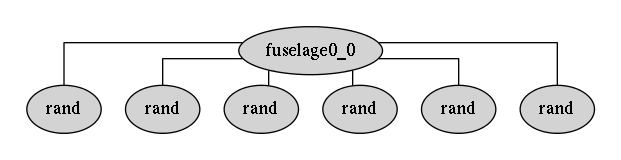

In [12]:
# Visualise the current tree:
from airconics import Topology
from IPython.display import Image

# nodes, edges, labels = gp.graph(tree)

# for edge in edges:
#     print(edge)`

    
# print(edges)

# graph = pydot.Dot(type='digraph')
# help(pydot.Edge)
# cluster_1 = pydot.Cluster('standard', label='standard')
# for node in nodes:
#     pydot_node = pydot.Node(label, shape='box')
#     cluster_1.add_node()

# cluster_2 = pydot.Cluster('mirrored', label='mirrored')


# print(config.export_graphviz())

graph = config.pydot_graph()
Image(graph.create_png())


In [7]:
nodes, labels, edges = gp.graph(tree)
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [8]:
def evalTopology(individual):
    # Transform the tree expression to functionnal Python code
    # Run the generated routine
    global config
    config.run(individual, pset)
    return config.temp_fitness(),
    
toolbox.register("evaluate", evalTopology)
toolbox.register("select", tools.selTournament, tournsize=7)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

def main():
    np.random.seed(69)
    
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    algorithms.eaSimple(pop, toolbox, 0.5, 0.2, 40, stats, halloffame=hof)
    
    return pop, hof, stats


pop, hof, stats = main()

hof

Attempting to construct Fuselage geometry...
hello
Surface fit attempt 1
Attempting loft surface fit with network density
                setup [35 30 15  5 20]


ValueError: invalid null reference in method 'TColgp_HArray1OfPnt_SetValue', argument 3 of type 'gp_Pnt const &'

In [ ]:
best = hof[0]

nodes, edges, labels = gp.graph(best)
print(best)

config.run(best, pset)

print(config)

from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

renderer = TornadoWebRenderer()

config.Display(renderer)
renderer

In [ ]:
# Visualise the best tree:
